### Imports

In [2]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd


### Data wrangling and Interpretation and Finalisation

In [3]:

df=pd.read_csv("mtbs_tropical_annotations.tsv", sep="\t")

#take the interested columns and make a new dataframe cleaned
df_cleaned= df_small = df[[
    "structure_smiles",
    "structure_taxonomy_npclassifier_01pathway",
    "structure_taxonomy_npclassifier_02superclass",
    "structure_taxonomy_npclassifier_03class"
]]


#remove rows with missing structure_smiles
df_cleaned = df.dropna(subset=["structure_smiles"], axis=0)

#check for duplicated smiles
df_cleaned.duplicated(subset=["structure_smiles"]).sum()

#collapse duplicate smiles by taking the most common class, subclass, my_class
def take_most_common(series: pd.Series):
    s = series.dropna()
    if s.empty:
        return np.nan
    return s.value_counts().idxmax()

#rename columns for easier handling
df_cleaned = df_cleaned.rename(columns={
    "structure_smiles": "smiles",
    "structure_taxonomy_npclassifier_01pathway": "class",
    "structure_taxonomy_npclassifier_02superclass": "subclass",
    "structure_taxonomy_npclassifier_03class": "my_class"
})

#collapse duplicates
df_collapsed = (
    df_cleaned
    .groupby("smiles", as_index=False)[["class", "subclass", "my_class"]]
    .agg(take_most_common)
)

#now I give an id to each smiles as in R code 
df_collapsed["SID"] = ["S" + str(i+1) for i in range(len(df_collapsed))]
df_collapsed = df_collapsed[["SID", "smiles", "class", "subclass", "my_class"]]


#calculate chemical descriptors
def calc_desc(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "RingCount": Descriptors.RingCount(mol),
        "FractionCSP3": Descriptors.FractionCSP3(mol)
    }

desc_list = df_collapsed["smiles"].apply(calc_desc)
desc_df = pd.DataFrame(desc_list.tolist())
df_final = pd.concat([df_collapsed, desc_df], axis=1)




In [4]:
#export final dataframe to csv
df_final.to_csv("mtbs_tropical_descriptors.csv", index=False)

In [5]:
df_final.head()

,SID,smiles,class,subclass,my_class,MolWt,LogP,TPSA,HBD,HBA,RingCount,FractionCSP3
0,S1,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,Fatty acyls,Fatty alcohols,292.466,5.8258,0.00,0,0,0,0.454545
1,S2,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,Fatty acyls|Fatty Acids and Conjugates,Fatty alcohols|Unsaturated fatty acids,282.471,5.8837,0.00,0,0,0,0.619048
2,S3,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,Fatty acyls,Fatty alcohols,308.465,4.4694,20.23,1,1,0,0.545455
3,S4,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,Lysine alkaloids,Piperidine alkaloids,297.442,4.0885,20.31,0,1,1,0.550000
4,S5,C#CC#CC=CC=CC=CCCO,Fatty acids,Fatty Acids and Conjugates,Unsaturated fatty acids,172.227,1.6740,20.23,1,1,0,0.166667


### Visualization starts with different types of Plots

#### Try of all PCA and Violin plots together

Text(0.5, 973.6753393665158, 'PC1 (polarity / lipophilicity gradient)')

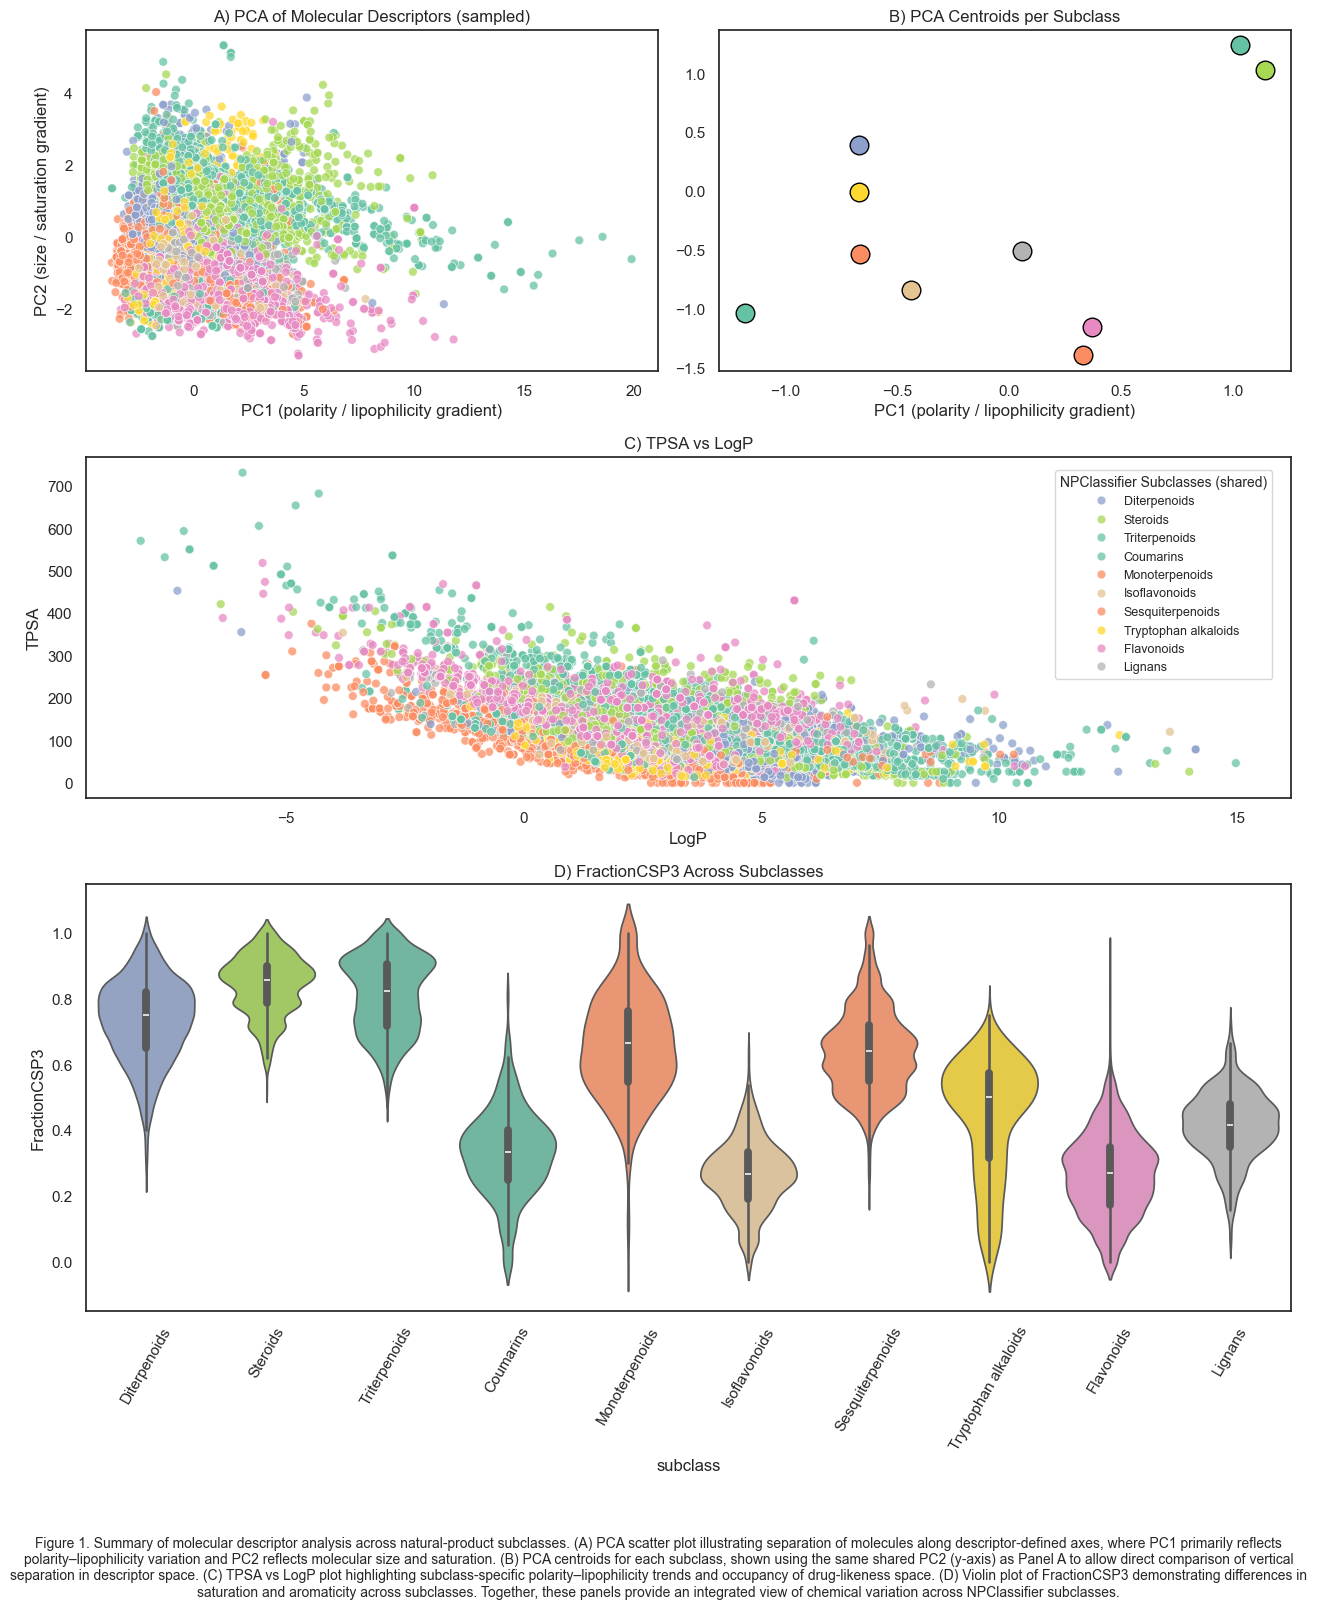

In [96]:
sns.set_theme(style="white")

# -------------------------------------------------------------------------
# 1) PREPARE COLORS
# -------------------------------------------------------------------------
top_sub = df_final["subclass"].value_counts().index[:10]
palette = sns.color_palette("Set2", n_colors=len(top_sub))
color_map = dict(zip(top_sub, palette))

# Subset for plotting
df_plot = df_final[df_final["subclass"].isin(top_sub)].copy()

# PCA prep
desc_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RingCount", "FractionCSP3"]
X = df_plot[desc_cols].dropna()

X_scaled = StandardScaler().fit_transform(X)
pcs = PCA(n_components=2).fit_transform(X_scaled)

df_pca = df_plot.loc[X.index].copy()
df_pca["PC1"], df_pca["PC2"] = pcs[:, 0], pcs[:, 1]
centroids = df_pca.groupby("subclass")[["PC1", "PC2"]].mean()

# -------------------------------------------------------------------------
# 2) SUMMARY FIGURE (A, B on top; C middle; D bottom)
# -------------------------------------------------------------------------
fig = plt.figure(figsize=(13, 15))

# Grid layout: 3 rows, 2 columns
# Row 1: A (left), B (right)
# Row 2: C (left, full width but using 2 panels visually aligned)
# Row 3: D (full-width violin)

gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.2, 1.5])

# ---------------- Panel A — PCA scatter ----------------
axA = fig.add_subplot(gs[0, 0])
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="subclass", palette=color_map,
    s=40, alpha=0.75, ax=axA
)
axA.set_title("A) PCA of Molecular Descriptors (sampled)", fontsize=12)
axA.legend_.remove()

# ---------------- Panel B — PCA centroids ----------------
axB = fig.add_subplot(gs[0, 1])
for sub in centroids.index:
    axB.scatter(
        centroids.loc[sub, "PC1"], centroids.loc[sub, "PC2"],
        s=180, color=color_map[sub], edgecolor="black"
    )
   
axB.set_title("B) PCA Centroids per Subclass", fontsize=12)



# ---------------- Panel C — TPSA vs LogP (full width) ----------------
axC = fig.add_subplot(gs[1, :])
sns.scatterplot(
    data=df_plot, x="LogP", y="TPSA",
    hue="subclass", palette=color_map,
    s=40, alpha=0.75, ax=axC
)
axC.set_title("C) TPSA vs LogP", fontsize=12)
axC.legend_.remove()

# ---- Clean legend placed inside Panel C (top-right corner) ----
handles, labels = axA.get_legend_handles_labels()

axC.legend(
    handles,
    labels,
    title="NPClassifier Subclasses (shared)",
    loc="upper right",
    bbox_to_anchor=(0.99, 0.98),   # adjust to push legend slightly inward
    frameon=True,
    fontsize=9,
    title_fontsize=10
)



# ---------------- Panel D — Violin plot (bottom full width) ----------------
axD = fig.add_subplot(gs[2, :])
sns.violinplot(
    data=df_plot,
    x="subclass",
    y="FractionCSP3",
    hue="subclass",
    palette=color_map,
    ax=axD,
    legend=False
)
axD.set_title("D) FractionCSP3 Across Subclasses", fontsize=12)
axD.tick_params(axis='x', rotation=60)

plt.tight_layout()

# -------------------------------------------------------------------------
# 3) CAPTION
# -------------------------------------------------------------------------
caption = (
    "Figure 1. Summary of molecular descriptor analysis across natural-product subclasses. "
    "(A) PCA scatter plot illustrating separation of molecules along descriptor-defined axes, "
    "where PC1 primarily reflects polarity–lipophilicity variation and PC2 reflects molecular "
    "size and saturation. (B) PCA centroids for each subclass, shown using the same shared PC2 "
    "(y-axis) as Panel A to allow direct comparison of vertical separation in descriptor space. "
    "(C) TPSA vs LogP plot highlighting subclass-specific polarity–lipophilicity trends and "
    "occupancy of drug-likeness space. (D) Violin plot of FractionCSP3 demonstrating differences "
    "in saturation and aromaticity across subclasses. Together, these panels provide an integrated "
    "view of chemical variation across NPClassifier subclasses.")

fig.text(
    0.5, -0.03,
    caption,
    ha="center",
    va="top",
    fontsize=10,
    wrap=True
)
axA.set_xlabel("PC1 (polarity / lipophilicity gradient)")
axA.set_ylabel("PC2 (size / saturation gradient)")


axB.set_xlabel("PC1 (polarity / lipophilicity gradient)")



#### Viloin plot first try Top 10 Classifiers

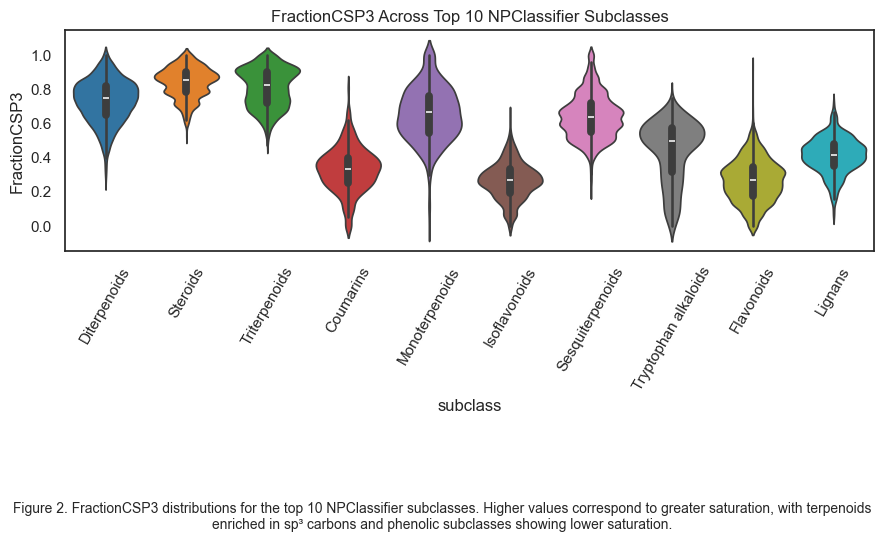

In [28]:
# --- Select top 10 NPClassifier subclasses ---
top_sub = df_final["subclass"].value_counts().index[:10]
df_plot = df_final[df_final["subclass"].isin(top_sub)].copy()

plt.figure(figsize=(9,5))

sns.violinplot(
    data=df_plot,
    x="subclass",
    y="FractionCSP3",
    hue="subclass",
    palette="tab10",
    legend=False
)

plt.xticks(rotation=60)
plt.title("FractionCSP3 Across Top 10 NPClassifier Subclasses")

plt.tight_layout(rect=[0, 0.12, 1, 1])  # make space for caption

# --- Paper-style caption ---
caption = (
    "Figure 2. FractionCSP3 distributions for the top 10 NPClassifier subclasses. Higher "
    "values correspond to greater saturation, with terpenoids enriched in sp³ carbons and "
    "phenolic subclasses showing lower saturation."
)

plt.gcf().text(
    0.5, -0.02,
    caption,
    ha="center",
    va="top",
    fontsize=10,
    wrap=True
)

plt.show()


#### Histogram plots TPSA 

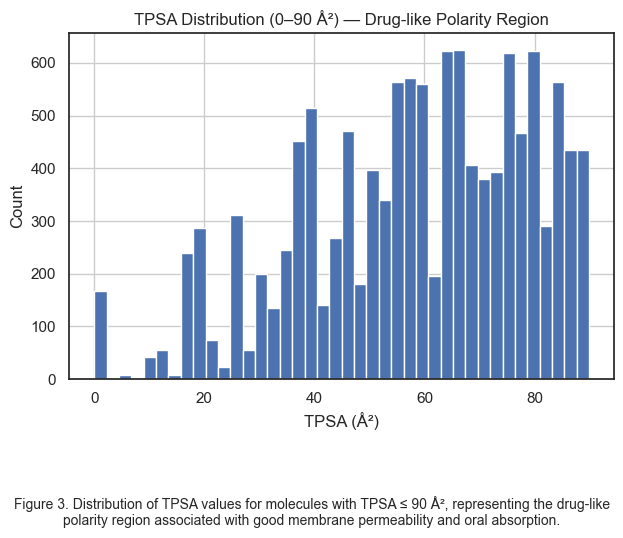

In [ ]:
#TPSA = Topological Polar Surface Area a indicator of overall polarity.
#Most medicinal chemistry papers visualize TPSA in the 0–90 Å² region.
#TPSA < 90 Å² is the “sweet spot” for
# cell-membrane permeability
#  oral absorption
#  drug-likeness
df_tpsa = df_final[df_final["TPSA"] <= 90]

df_tpsa["TPSA"].hist(bins=40)
plt.xlabel("TPSA (Å²)")
plt.ylabel("Count")
plt.title("TPSA Distribution (0–90 Å²) — Drug-like Polarity Region",loc="center")

caption = (
    "Figure 3. Distribution of TPSA values for molecules with TPSA ≤ 90 Å², representing "
    "the drug-like polarity region associated with good membrane permeability and oral "
    "absorption."
)

plt.gcf().text(
    0.5, -0.05,
    caption,
    ha="center",
    va="top",
    fontsize=10,
    wrap=True
)

plt.tight_layout(rect=[0, 0.05, 1, 1])


plt.show()




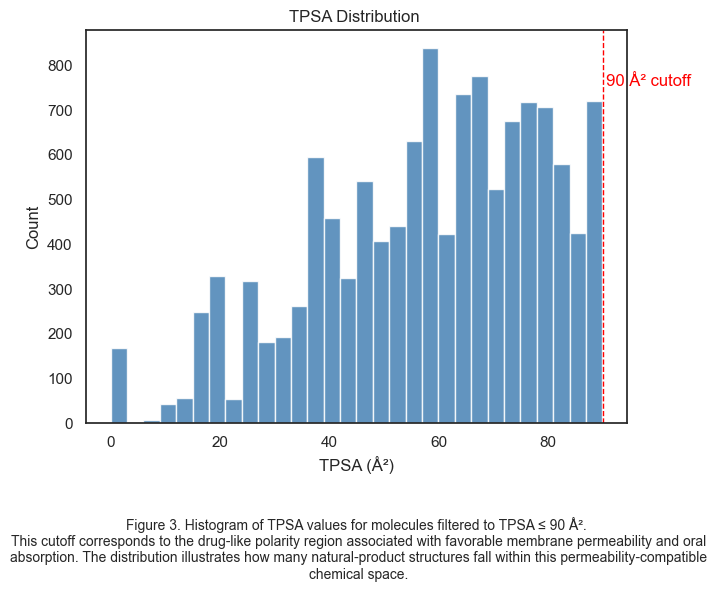

In [27]:
df_tpsa = df_final[df_final["TPSA"] <= 90]

plt.figure(figsize=(7,5))

counts, bins, patches = plt.hist(
    df_tpsa["TPSA"],
    bins=30,
    color="steelblue",
    alpha=0.85,
    edgecolor="white"
)

# Drug-likeness cutoff
plt.axvline(90, color="red", linestyle="--", linewidth=1)
plt.text(90.5, counts.max()*0.9, "90 Å² cutoff", color="red")

plt.xlabel("TPSA (Å²)")
plt.ylabel("Count")
plt.title("TPSA Distribution ")

caption = (
    "Figure 3. Histogram of TPSA values for molecules filtered to TPSA ≤ 90 Å². "
    "\nThis cutoff corresponds to the drug-like polarity region associated with favorable "
    "membrane permeability and oral absorption. The distribution illustrates how many "
    "natural-product structures fall within this permeability-compatible chemical space."
)


plt.gcf().text(
    0.5, -0.05,
    caption,
    ha="center",
    va="top",
    fontsize=10,
    wrap=True
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.tight_layout()
plt.show()


### Figure1 Summary of all Plots finalized

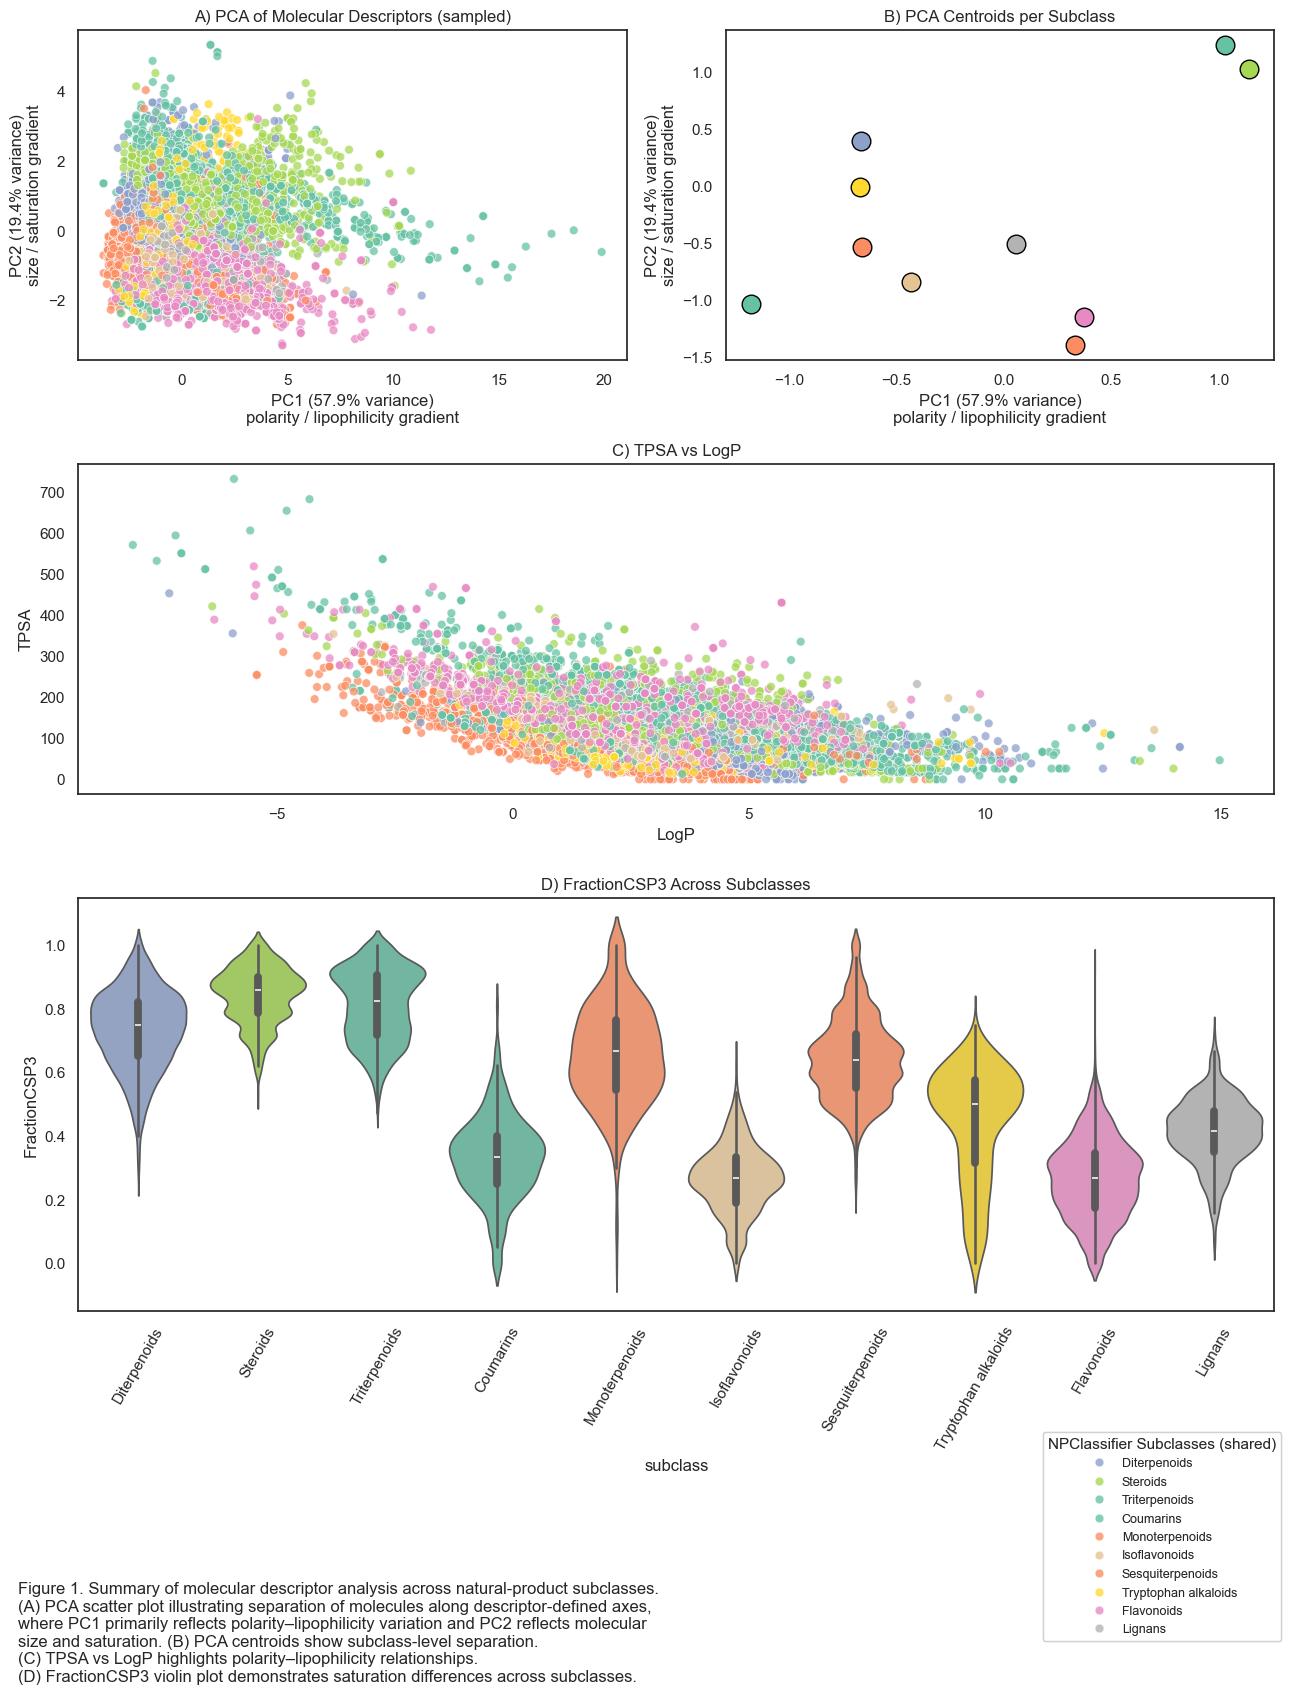

In [100]:
sns.set_theme(style="white")

# -------------------------------------------------------------------------
# 1) PREPARE COLORS
# -------------------------------------------------------------------------
top_sub = df_final["subclass"].value_counts().index[:10]
palette = sns.color_palette("Set2", n_colors=len(top_sub))
color_map = dict(zip(top_sub, palette))

# Subset for plotting
df_plot = df_final[df_final["subclass"].isin(top_sub)].copy()

# PCA prep
desc_cols = ["MolWt", "LogP", "TPSA", "HBD", "HBA", "RingCount", "FractionCSP3"]
X = df_plot[desc_cols].dropna()

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)

# % variance for PC1 and PC2
pc1_var, pc2_var = pca.explained_variance_ratio_ * 100


df_pca = df_plot.loc[X.index].copy()
df_pca["PC1"], df_pca["PC2"] = pcs[:, 0], pcs[:, 1]
centroids = df_pca.groupby("subclass")[["PC1", "PC2"]].mean()

# -------------------------------------------------------------------------
# 2) SUMMARY FIGURE (A, B on top; C middle; D bottom)
# -------------------------------------------------------------------------
fig = plt.figure(figsize=(13, 15))

# Grid layout: 3 rows, 2 columns
# Row 1: A (left), B (right)
# Row 2: C (left, full width but using 2 panels visually aligned)
# Row 3: D (full-width violin)

gs = fig.add_gridspec(3, 2, height_ratios=[1.2, 1.2, 1.5])

# ---------------- Panel A — PCA scatter ----------------
axA = fig.add_subplot(gs[0, 0])
sns.scatterplot(
    data=df_pca, x="PC1", y="PC2",
    hue="subclass", palette=color_map,
    s=40, alpha=0.75, ax=axA
)
axA.set_title("A) PCA of Molecular Descriptors (sampled)", fontsize=12)
# Add axis labels to Panel A
axA.set_xlabel(f"PC1 ({pc1_var:.1f}% variance)\npolarity / lipophilicity gradient")
axA.set_ylabel(f"PC2 ({pc2_var:.1f}% variance)\nsize / saturation gradient")

axA.legend_.remove()

# ---------------- Panel B — PCA centroids ----------------
axB = fig.add_subplot(gs[0, 1])
for sub in centroids.index:
    axB.scatter(
        centroids.loc[sub, "PC1"], centroids.loc[sub, "PC2"],
        s=180, color=color_map[sub], edgecolor="black"
    )
   
axB.set_title("B) PCA Centroids per Subclass", fontsize=12)
# Add axis labels to Panel B
axB.set_xlabel(f"PC1 ({pc1_var:.1f}% variance)\npolarity / lipophilicity gradient")
axB.set_ylabel(f"PC2 ({pc2_var:.1f}% variance)\nsize / saturation gradient")




# ---------------- Panel C — TPSA vs LogP (full width) ----------------
axC = fig.add_subplot(gs[1, :])
sns.scatterplot(
    data=df_plot, x="LogP", y="TPSA",
    hue="subclass", palette=color_map,
    s=40, alpha=0.75, ax=axC
)
axC.set_title("C) TPSA vs LogP", fontsize=12)
axC.legend_.remove()




# ---------------- Panel D — Violin plot (bottom full width) ----------------
axD = fig.add_subplot(gs[2, :])
sns.violinplot(
    data=df_plot,
    x="subclass",
    y="FractionCSP3",
    hue="subclass",
    palette=color_map,
    ax=axD,
    legend=False
)
axD.set_title("D) FractionCSP3 Across Subclasses", fontsize=12)
axD.tick_params(axis='x', rotation=60)

plt.tight_layout()

# -------------------------------------------------------------------------
# 3) CLEAN TWO-COLUMN FOOTER: CAPTION LEFT (70%) + LEGEND RIGHT (30%)
# -------------------------------------------------------------------------

caption = (
    "Figure 1. Summary of molecular descriptor analysis across natural-product subclasses. "
    "\n(A) PCA scatter plot illustrating separation of molecules along descriptor-defined axes, "
    "\nwhere PC1 primarily reflects polarity–lipophilicity variation and PC2 reflects molecular "
    "\nsize and saturation. (B) PCA centroids show subclass-level separation. "
    "\n(C) TPSA vs LogP highlights polarity–lipophilicity relationships. "
    "\n(D) FractionCSP3 violin plot demonstrates saturation differences across subclasses."
)

# Shared baseline for both columns
baseline_y = -0.06

# ---- LEFT COLUMN: CAPTION (wrap only in left 70% of width) ----
fig.text(
    0.02, baseline_y,
    caption,
    ha="left",
    va="top",
    fontsize=12,
    wrap=True,
    bbox=dict(facecolor='none', edgecolor='none', boxstyle='square,pad=0.1'),
)

# To restrict caption width, add an invisible text box defining the right edge
# (Matplotlib wraps relative to figure width unless constrained)
fig.text(
    0.70, baseline_y + 0.0001,  # invisible bounding guide at 70% width
    "",
    ha="left",
    va="top"
)

# ---- RIGHT COLUMN: LEGEND (30% width, pushed right) ----
handles, labels = axA.get_legend_handles_labels()

legend = fig.legend(
    handles,
    labels,
    title="NPClassifier Subclasses (shared)",
    loc="center",
    frameon=True,
    fontsize=9,
    title_fontsize=11
)

# Position legend using figure coordinates
legend.set_bbox_to_anchor((0.9, baseline_y + 0.03), transform=fig.transFigure)

fig.add_artist(legend)
plt.show()

